# Model 800 basicRt coupled steady state solution

This model shows example usage of the BasicRt model from the TerrainBento package.

BasicRt modifies Basic by allowing for two lithologies:

$\frac{\partial \eta}{\partial t} = - K(\eta,\eta_C) A^{1/2}S + D\nabla^2 \eta$

$K(\eta, \eta_C ) = w K_1 + (1 - w) K_2$

$w = \frac{1}{1+\exp \left( -\frac{(\eta -\eta_C )}{W_c}\right)}$

where $W_c$ is the contact-zone width.

Refer to [REF MANUSCRIPT] for the definition of all symbols. 

This notebook (a) shows the initialization and running of this model, (b) saves a NetCDF file of the topography, which we will use to make an oblique Paraview image of the landscape, and (c) creates a slope-area plot at steady state.

In [1]:
# import required modules
import os
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 20})
%matplotlib inline

from landlab import imshow_grid
from landlab.io.netcdf import write_netcdf

from terrainbento import BasicRt

In [2]:
# create the parameter dictionary needed to instantiate the model 
# all parameters used are specified in this notebook block
params = {'number_of_node_rows' : 100,
          'number_of_node_columns' : 160,
          'node_spacing' : 10.0,
          'east_boundary_closed' : False,
          'north_boundary_closed' : False,
          'west_boundary_closed' : False,
          'south_boundary_closed' : False,
          'dt' : 10.0,
          'K_rock_sp' : 0.001,
          'K_till_sp' : 0.01,
          'm_sp' : 0.5,
          'n_sp' : 1.0,
          'linear_diffusivity' : 0.1,
          'outlet_lowering_rate' : 0.0005,
          'output_filename' : 'model_000_output',
          'rock_till_file__name' : os.path.join('..', 'input_data', 'ss_test_rock_till.txt'),
          'contact_zone__width' : 1.0
}

In [3]:
# initialize the model by passing the parameter dictionary
model = BasicRt(params=params)

# set a tolerance for determining steady state
tolerance = 0.0001

In [4]:
# run the model, it will take 110,000 years

# set dt and initialize the elapsed_time variable
dt = params['dt']
elapsed_time = 0 

# initialize a variable to identify if steady state has been reached
keep_running = True

# run the model until stead state has been reached. 
while keep_running == True:
    
    # save the pre-model-step topography of the core nodes to assess steady state. 
    pre_topo = model.grid.at_node['topographic__elevation'][model.grid.core_nodes]
    
    # run the model one step
    model.run_one_step(dt)
    
    # save the post-model step topography of the core nodes to assess steady state. 
    post_topo = model.grid.at_node['topographic__elevation'][model.grid.core_nodes]
    
    # increment elapsed time
    elapsed_time += dt
    
    # assess if steady state has been reached. 
    if max(abs(pre_topo - post_topo)) <= tolerance: # 1 mm
        keep_running = False
    
    # if time rounds to 10,000 years, print out a log message. 
    if elapsed_time % 10000 == 0:
        print('Elapsed time: ', elapsed_time)
        print('Maximum Topographic Change/Tolerance: ', np.round(max(abs(pre_topo - post_topo))/tolerance, decimals=2))       

Elapsed time:  10000.0
Maximum Topographic Change/Tolerance:  41.8
Elapsed time:  20000.0
Maximum Topographic Change/Tolerance:  24.88
Elapsed time:  30000.0
Maximum Topographic Change/Tolerance:  18.91
Elapsed time:  40000.0
Maximum Topographic Change/Tolerance:  15.26
Elapsed time:  50000.0
Maximum Topographic Change/Tolerance:  14.51
Elapsed time:  60000.0
Maximum Topographic Change/Tolerance:  17.57
Elapsed time:  70000.0
Maximum Topographic Change/Tolerance:  16.63
Elapsed time:  80000.0
Maximum Topographic Change/Tolerance:  10.96
Elapsed time:  90000.0
Maximum Topographic Change/Tolerance:  12.86
Elapsed time:  100000.0
Maximum Topographic Change/Tolerance:  9.65
Elapsed time:  110000.0
Maximum Topographic Change/Tolerance:  3.36


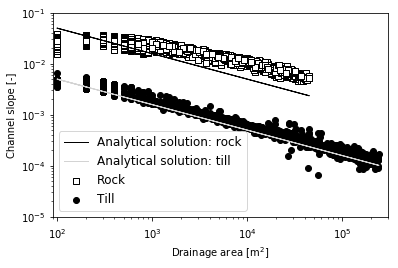

In [6]:
# MAKE SLOPE-AREA PLOT

# assign area_array and slope_array for ROCK
area_array_rock = model.grid.at_node['drainage_area'][(model.grid.node_x > 10)&(model.grid.node_x < 1580)&(model.grid.node_y >=500)&(model.grid.node_y<980)]
slope_array_rock = model.grid.at_node['topographic__steepest_slope'][(model.grid.node_x > 10)&(model.grid.node_x < 1580)&(model.grid.node_y >=500)&(model.grid.node_y<980)]

# assign area_array and slope_array for TILL
area_array_till = model.grid.at_node['drainage_area'][(model.grid.node_x > 10)&(model.grid.node_x < 1580)&(model.grid.node_y >10)&(model.grid.node_y<500)]
slope_array_till = model.grid.at_node['topographic__steepest_slope'][(model.grid.node_x > 10)&(model.grid.node_x < 1580)&(model.grid.node_y >10)&(model.grid.node_y<500)]

# instantiate figure and plot
fig = plt.figure(figsize=(6, 3.75))
slope_area = plt.subplot()

# create an array for the detachment-limited analytical solution
u = params['outlet_lowering_rate']# m/yr, uplift or baselevel lowering rate
k_rock = params['K_rock_sp'] # rock fluvial erodibility
k_till = params['K_till_sp'] # rock fluvial erodibility
m = params['m_sp'] # discharge exponent
n = params['n_sp'] # slope exponent


# calculate analytical slope from area field for ROCK
analytical_slope_array_rock = np.power((u / k_rock), 1 / n) * np.power(area_array_rock, -m/n)

# plot the analytical solution for ROCK
slope_area.plot(area_array_rock, analytical_slope_array_rock, linestyle='-',
                color='k', linewidth = 1, label = 'Analytical solution: rock')

#plot the data for ROCK
slope_area.scatter(area_array_rock, slope_array_rock, marker='s', edgecolor='0', color='1', 
                   label = 'Rock')

#####################################################################
# calculate analytical slope from area field for TILL
analytical_slope_array_till = np.power((u / k_till), 1 / n) * np.power(area_array_till, -m/n)

# plot the analytical solution for TILL
slope_area.plot(area_array_till, analytical_slope_array_till, linestyle='-',
                color='lightgrey', linewidth = 1, label = 'Analytical solution: till')

#plot the data for TILL
slope_area.scatter(area_array_till, slope_array_till, color='k', 
                   label = 'Till') 

#make axes log and set limits
slope_area.set_xscale('log')
slope_area.set_yscale('log')

slope_area.set_xlim(9*10**1, 3*10**5)
slope_area.set_ylim(1e-5, 1e-1)

#set x and y labels
slope_area.set_xlabel(r'Drainage area [m$^2$]')
slope_area.set_ylabel('Channel slope [-]')
slope_area.legend(scatterpoints=1,prop={'size':12})
slope_area.tick_params(axis='x', which='major', pad=7)

# save out an output figure
output_figure = os.path.join('output_figures/maintext_rock_till_slope_area.eps')
fig.savefig(output_figure, bbox_inches='tight', dpi=1000) # save figure

In [7]:
#export NetCDF for Paraview image of topography
output_file = os.path.join('output_netcdfs/maintext_rock_till.nc')
write_netcdf(output_file, model.grid, format='NETCDF3_64BIT', names='topographic__elevation')

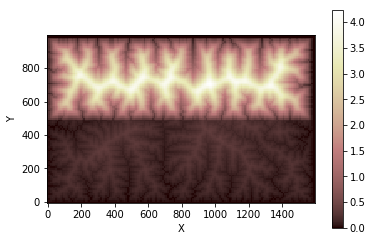

In [8]:
# make a plot of the final steady state topography
imshow_grid(model.grid, 'topographic__elevation')